<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjdFlCXx3ZNV-JwPuvs8nl9uGiG_Ey77aIEx5r5t4bbGXpWpw3Jy2c
Mounted at /content/drive


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

In [2]:
%cd /content/drive/MyDrive/git/COMP551/projects/p2

/content/drive/MyDrive/git/COMP551/projects/p2


# **Mini-Project 2: Optimization and Text Classification**

## PART I: Optimization


In [3]:
import pandas as pd
import numpy as np
import my_gd
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint
np.random.seed(1234)

### Logistic Regression

In [4]:
logistic = lambda z: 1./ (1 + np.exp(-z))   
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, batch_size=None):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.batch_size = batch_size

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            g = self.stochastic_gradient(x, y, self.batch_size)
            self.gradient_norm = np.linalg.norm(g)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def stochastic_gradient(self, x, y, batch_size=None):
        N = x.shape[0]
        if batch_size is None:              # gradient on full data by default
          batch_size = N
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:batch_size,:]
        y_batch = y[inds][:batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/batch_size
        return stoch_grad


### Cost Function

In [5]:
def cost_fn(y, yh):
    J = np.mean(y * np.log1p(np.exp(-yh)) + (1-y) * np.log1p(np.exp(yh)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

### Gradient Descent Hyper-Tuning

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [7]:
def gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic'):
  figure, axis = plt.subplots(3, 1)
  axis[0].set_title("Train Accuracy")
  axis[1].set_title("Validation Accuracy")
  axis[2].set_title("Gradient Norm")

  for i, lr in enumerate(lr_range):
    acc_train_arr = np.zeros((max_iters_range.size))
    acc_val_arr = np.zeros((max_iters_range.size))
    g_norm_arr = np.zeros((max_iters_range.size))
    for j, max_iters in enumerate(max_iters_range):
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-4, max_iters=max_iters, verbose=False)
      reg.fit(x_train, y_train)

      # compute error
      acc_train_arr[j], acc_val_arr[j] = 1 - cost_fn(reg.predict(x_train), y_train), 1 - cost_fn(reg.predict(x_val), y_val)
      g_norm_arr[j] = reg.gradient_norm
    # add plot lines
    axis[0].plot(max_iters_range, acc_train_arr, label="%0.6f" % lr)
    axis[1].plot(max_iters_range, acc_val_arr, label="%0.6f" % lr)
    axis[2].plot(max_iters_range, g_norm_arr, label="%0.6f" % lr)

  for i, subplot in enumerate(axis):
    subplot.set_xlabel("Number of Iterations")
    if i in range(2):
      subplot.set_ylabel("Accuracy")
    else:
      subplot.set_ylabel("Gradient Norm")
    subplot.legend()
  figure.tight_layout()
  plt.show()



### 1. Import Data

In [8]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

### Shuffle Data

In [9]:
inds = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[inds, :], y_train[inds]

### 2. Learning Rate and Number of Iterations Tuning

The learning rate and the max number of iterations will be determined empirically. We will start by high learning rates. The accuracy per number of iterations will be plot for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


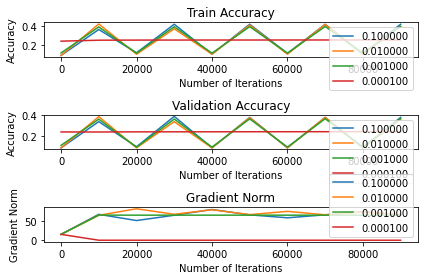

In [51]:
lr_range = np.array([0.1, 0.01, 0.001, 0.0001])
max_iters_range = np.arange(1,100000,10001)
gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic')

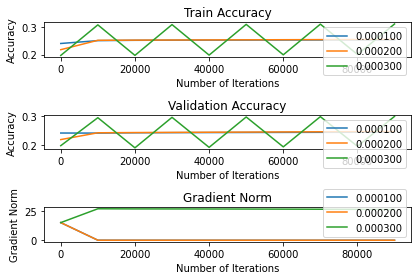

In [68]:
lr_range = np.array([0.0001, 0.0002, 0.0003])
max_iters_range = np.arange(1,100000,10001)
gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic')

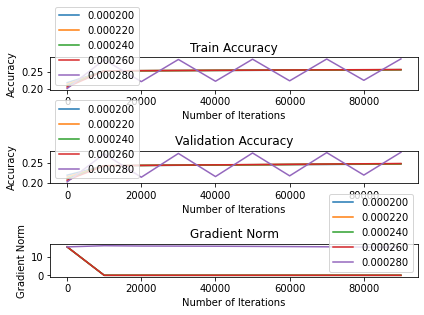

In [69]:
lr_range = np.array([0.0002, 0.00022, 0.00024, 0.00026,0.00028])
max_iters_range = np.arange(1,100000,10001)
gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic')

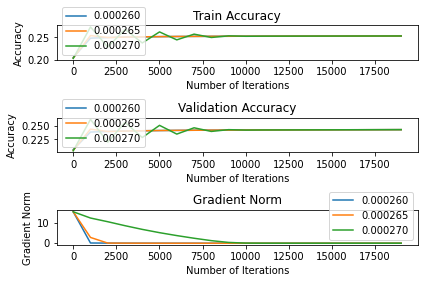

In [55]:
lr_range = np.array([0.00026,0.000265, 0.00027])
max_iters_range = np.arange(1,20000,1001)
gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic')

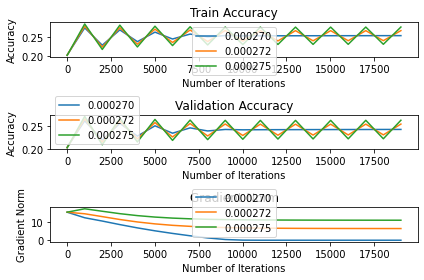

In [57]:
lr_range = np.array([0.00027,.000272, 0.000275])
max_iters_range = np.arange(1,20000,1001)
gd_hypertuning_plots(lr_range, max_iters_range, x_train, y_train, x_val, y_val, reg_type='logistic')

### Results:

From the empirically testing, we decided to use a learning rate of 0.000271 and a maximum number of iterations of 1 000 000.

In [67]:
lr = 0.000271
max_iters = 2000000
epsilon = 0.0001

reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True)
reg.fit(x_train, y_train)

# compute error
acc_train, acc_val = 1 - cost_fn(reg.predict(x_train), y_train), 1 - cost_fn(reg.predict(x_val), y_val)

print("train accuracy: {acc_train}".format(acc_train=acc_train))
print("validation accuracy: {acc_val}".format(acc_val=acc_val))

terminated after 1000000 iterations, with norm of the gradient equal to 54.8420988042136
the weight found: [ 5.05983158e-01  1.21525388e-01 -3.96970355e-02 -1.72448126e-02
  2.46974260e-02  1.70477435e-01  2.26760521e+00  2.36794237e-02
 -1.98271150e+01]
train accuracy: 0.40398635687084394
validation accuracy: 0.3918111634521061
